In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
import pandas as pd
import xml.etree.ElementTree as et
import datetime
from skimage.io import imread, imsave
from imageio import volread as imread
import tifffile
import pystackreg
from pystackreg import StackReg
from skimage.filters import threshold_otsu
from pystackreg.util import to_uint16   # make sure version 0.2.5 (not anything below)
# from ims_to_tiff import convert_to_tif  
from tqdm.notebook import tqdm
import seaborn as sns
import pylab as pl

# Converting to TIF

There is an automated way to do this on the command line -- below is the documentation:

https://docs.google.com/document/d/1O-mWoCaFsKmQY7QfEU1NhL3cyS8SfPCvKUoiIK5zcQQ/edit

If you want to run in jupyter notebook, continue

In [ ]:
IMG_DIR = "IMS_IMAGES_DIRECTORY_PATH"

In [ ]:
# Change "reg_ex" with a regular expression for all files in the directory
# for example, if all of the files have the word "Plate" in it, the reg_ex should be replaced with Plate
cycles = glob.glob(f'{IMG_DIR}/*reg_ex*')     

In [ ]:
error_files = []
for i in cycles:
    ims = glob.glob(f'{i}/*')
    for file in ims:
        try:
            sourceFile = file
            destFile = "tif/" + file[:-4]+'.tif'
            #print(destFile)
            convert_to_tif(sourceFile, destFile)
        except:
            print(f'{i} has B-tree error or import error')
            error_files.append(file)
            pass
# you can check for any error files by printing out the error_files list

# Registration (Testing)

This step is to test the registration on one moved image compared to its reference image before moving onto performing the registration on the entire dataset.

In [ ]:
sample = "NAME_OF_SAMPLE"   # for example "061224_CellPainting_CorticalNeurons"  -- but unnecessary if the notebook is inside of the sample directory already
TIF_DIR = "tif"
REF_CYCLE_DIR = "Cycle_Field_1"
MOV_CYCLE_DIR = "Cycle_1_Field_1"

In [ ]:
ref = imread(f'{TIF_DIR}/{REF_CYCLE_DIR}/Cycle_F000.tif') # change reference.tif with real name of image
mov = imread(f'{TIF_DIR}/{MOV_CYCLE_DIR}/Cycle_1_F000.tif') # change moved.tif with real name of image
 
ref_max = ref.max(0)   # max proj of z for each channel in reference
ref_binary = ref_max[0] > threshold_otsu(ref_max[0])  # binarizing 0th channel - change for DNA channel 

mov_max = mov.max(0)  # max projection by each cycle in for loop (ref above)
mov_binary = mov_max[0] > threshold_otsu(mov_max[0]) # binary of moved image
    
sr = StackReg(StackReg.RIGID_BODY)
tmat = sr.register(ref_binary, mov_binary)   # creating transformation matrix 
out_binary = sr.transform(mov_binary) 

In [ ]:
tmat

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (20,60))
axs = axs.ravel()

im_reg = np.zeros((2048, 2048,3)) # empty color image
im_reg[...,0] = ref_binary
im_reg[...,1] = out_binary
    
im_orig = np.zeros((2048, 2048,3))
im_orig[...,0] = ref_binary
im_orig[...,1] = mov_binary
    
axs[0].imshow(im_orig[0:1000, 0:1000])   #before reg
    
axs[1].imshow(im_reg[0:1000, 0:1000])   #after reg


axs[0].title.set_text('Before Registration')
axs[1].title.set_text('After Registration')

for ax in axs.flat:
    ax.set(xlabel='0:1000', ylabel='0:1000')

In [ ]:
reg = np.zeros(mov.shape, dtype=np.uint16) # initialize with the right dtype
for Z in range(mov.shape[0]): # Z 
    print(f"Z-plane: {Z} registering")
    for ch in range(mov.shape[1]): # channels
        reg[Z,ch,...] = sr.transform(mov[Z,ch,...], tmat=tmat)
        reg[Z,ch,...] = to_uint16(reg[Z,ch,...])

In [ ]:
# setting a small window of the image to check by eye -- you can change the numbers as you wish
reg_max = reg.max(0)
reg_v = reg_max[0, ...]
reg_v = reg_v[100:200, 100:200]
reg_v.shape

In [ ]:
# COMPARING BETWEEN ORIGNIAL IMAGE AND REGISTERED IMAGE -- looking by eye to check that the image has moved

orig = imread(f'{TIF_DIR}/{MOV_CYCLE_DIR}/Cycle_1_F000.tif')
orig = orig.max(0)
orig = orig[0, ...]
orig_v = orig[100:200, 100:200]

f, ax = plt.subplots(1,2, figsize = (20,60))
ax[0].imshow(orig_v)
ax[1].imshow(reg_v)
ax[0].title.set_text('Before Registration (DNA Channel)')
ax[1].title.set_text('After Registration (DNA Channel)')

for ax in ax.flat:
    ax.set(xlabel='100:1000', ylabel='100:1000')

print(orig_v," \n" , "\n",reg_v)

# Registration

In this step we will perform registration on the entire dataset.

In [ ]:
sample = "NAME_OF_SAMPLE"   # this was defined at the testing stage above\
output = "output"     # this will be the directory where all of the data other than the images will be saved

In [2]:
# Set up number of channels and number of FOVs

CYCLE_NUMS = 3
NUM_FOVS = 25

In [ ]:
# Creating the directories for the intermediate outputs

for i in range(CYCLE_NUMS):
    if i == 0:
        continue
    os.makedirs(f'tmat_Cyc_{i}')
    os.makedirs(f'reg_bin_Cyc_{i}')
    os.makedirs(f'reg_Cyc_{i}') 
    os.makedirs(f'tif/Cycle_{i}') 
os.makedirs(f'tif/Cycle_0')
os.makedirs('output')

In [ ]:
# Moving the images into their respective cycle directories, and removing empty original directories

for i in range(CYCLE_NUMS):
    if i == 0:
        os.system('mv tif/Cycle_F*/* tif/Cycle_0')
    os.system(f'mv tif/Cycle_*{i}*Field*/* tif/Cycle_{i}')

os.system(f'rm -rf tif/Cycle_*Field*')

In [ ]:
### CHECK IF REFERENCE FOV IS BEING MATCHED TO SAME MOVED FOV, ACROSS ALL CYCLES AND FOVS IN EVERY ITERATION

for c in range(CYCLE_NUMS-1):   
    refs = iter(sorted(glob.glob(f'tif/Cycle_0/*'))) # list of cycle 0 .tif 
    movs = iter(sorted(glob.glob(f'tif/Cycle_{c+1}/*'))) # cycle 1, 2, 3, .tif list --> FOV000, 001, (002 = error) 005 006 
    for FOV in range(0, NUM_FOVS): 
        #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
        ref_name = next(refs) 
        mov_name = next(movs)

        ref_num = ref_name.split('_F')[1][0:3]
        mov_num = mov_name.split('_F')[1][0:3]
        if ref_num != mov_num:
            print("False")

Jaccard index is a score to evaluate intersection divided by the union of the pixels in the image, which provides a metric of how overlapped the cells are.

By comparing the jaccard indices of before registration and after registration, one can evaluate how well the registration has performed.

In [ ]:
# define the jaccard index calculating function

def jaccard(img1, img2):
    assert img1.dtype == 'bool', 'input must be boolean'
    assert img2.dtype == 'bool', 'input must be boolean'
    AND = np.sum(img1&img2)
    OR = np.sum(img1|img2)
    J = AND/OR
    return J
reg_J = pd.DataFrame()     # dataframe of jaccard index of cells after registration
base_J = pd.DataFrame()     # dataframe of jaccard index of cells before registration

In [ ]:
# Here, we perform the registration for all cycles and FOVs

for c in range(CYCLE_NUMS-1):    
    refs = iter(sorted(glob.glob(f'tif/Cycle_0/*'))) # list of cycle 0 .tif 
    movs = iter(sorted(glob.glob(f'tif/Cycle_{c+1}/*'))) # cycle 1, 2, 3, .tif list --> FOV000, 001, (002 = error) 005 006 
    for FOV in range(0, NUM_FOVS): 
        #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
        ref_name = next(refs) 
        ref = imread(ref_name)
        ref = ref.astype(np.uint16)
        mov_name = next(movs)
        mov = imread(mov_name)
        mov = mov.astype(np.uint16)
        FOV_num = mov_name.split('_F')[1][0:3]
        print(f'cycle {c+1} field {FOV_num} ')

        ref_max = ref.max(0)
        ref_binary = ref_max[0] > threshold_otsu(ref_max[0]) # change 0 for whichever channel is the nuclei channel
        mov_max = mov.max(0)
        mov_binary = mov_max[0] > threshold_otsu(mov_max[0]) # change 0 for whichever channel is the nuclei channel
        print("Got threshold")
        sr = StackReg(StackReg.RIGID_BODY)  
        tmat = sr.register(ref_binary, mov_binary) 
        out = sr.transform(mov_binary) 
        out = pystackreg.util.to_uint16(out) 
        
        base_J.loc[FOV_num, str(c+1)] = jaccard(ref_binary, mov_binary)
        reg_J.loc[FOV_num, str(c+1)] = jaccard(ref_binary, out.astype('bool'))

        # save binary
        fname_to_save = f'reg_bin_Cyc_{c+1}' + f'/Cycle_{c+1}_F{FOV_num}_bin_reg.tif'
        print('Saving Binary Registered Images...', fname_to_save)
        tifffile.imwrite(fname_to_save, out, imagej=True, photometric = 'minisblack',metadata={'axes':'YX'})

        # save tmat
        print("saving tmat")
        np.save(f'tmat_Cyc_{c+1}' + f'/Cycle_{c+1}_F{FOV_num}_tmat.npy', tmat)
        
        # THE REGISTRATION STEP
        reg = np.zeros(mov.shape, dtype=np.uint16)               # initialize with the right dtype
        for Z in range(mov.shape[0]):
            print(f"Z-plane: {Z} registering")
            for ch in range(mov.shape[1]): 
                reg[Z,ch,...] = sr.transform(mov[Z,ch,...], tmat=tmat)
                reg[Z,ch,...] = to_uint16(reg[Z,ch,...])

        fname_to_save = f'reg_Cyc_{c+1}' + f'/Cycle_{c+1}_F{FOV_num}_reg.tif'
        print('Saving Registered Images...', fname_to_save)
        tifffile.imwrite(fname_to_save, reg, imagej=True,
                         photometric = 'minisblack',metadata={'axes':'ZCYX'})

# Saving jaccard index dataframes        
base_J.to_csv('output/base_J.csv')
reg_J.to_csv('output/reg_J.csv')

# Looking at X and Y pixel shifts and comparing them to the jaccard index shift from before to after registration

This step helps with looking at all of the X and Y shifts that are over a certain threshold number, defined by the user. Here it is defined as 15, but it can change depending on what kind of data you are working with, and what kind of max and min range of shift occured from the registration.

In [3]:
for idx, c in enumerate(range(CYCLE_NUMS-1)):     
    tmats = iter(glob.glob(f'tmat_Cyc_{c+1}/*'))
    for sFOV in range(0,NUM_FOVS): 
        tmat_name = next(tmats)
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]
        if (moveX > 15) | (moveY > 15)|(moveX < -15) | (moveY < -15):     # 15 is an arbitraty number
            print(c+1, tmat_name, moveX, moveY)

In [8]:
# Be sure to remove problematic FOVs and then updating NUM_FOVS with the new number of FOVs
dfX_shift = pd.DataFrame()
dfY_shift = pd.DataFrame()
for idx, c in enumerate(range(CYCLE_NUMS-1)):
    tmats = iter(sorted(glob.glob(f'tmat_Cyc_{c+1}/*')))
    for sFOV in range(0,NUM_FOVS):
        tmat_name = next(tmats)
        FOV_num = tmat_name.split('_F')[1][0:3]
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]

        dfX_shift.loc[FOV_num, str(c+1)] = moveX
        dfY_shift.loc[FOV_num, str(c+1)] = moveY
dfX_shift.to_csv('output/X_shift.csv')
dfY_shift.to_csv('output/Y_shift.csv')

In [9]:
base_J = pd.read_csv('output/base_J.csv')
reg_J = pd.read_csv('output/reg_J.csv')
dfY_shift = pd.read_csv("output/Y_shift.csv")
dfY_shift = dfY_shift.drop(["Unnamed: 0"], axis=1)
dfX_shift = pd.read_csv("output/X_shift.csv")
dfX_shift = dfX_shift.drop(["Unnamed: 0"], axis=1)

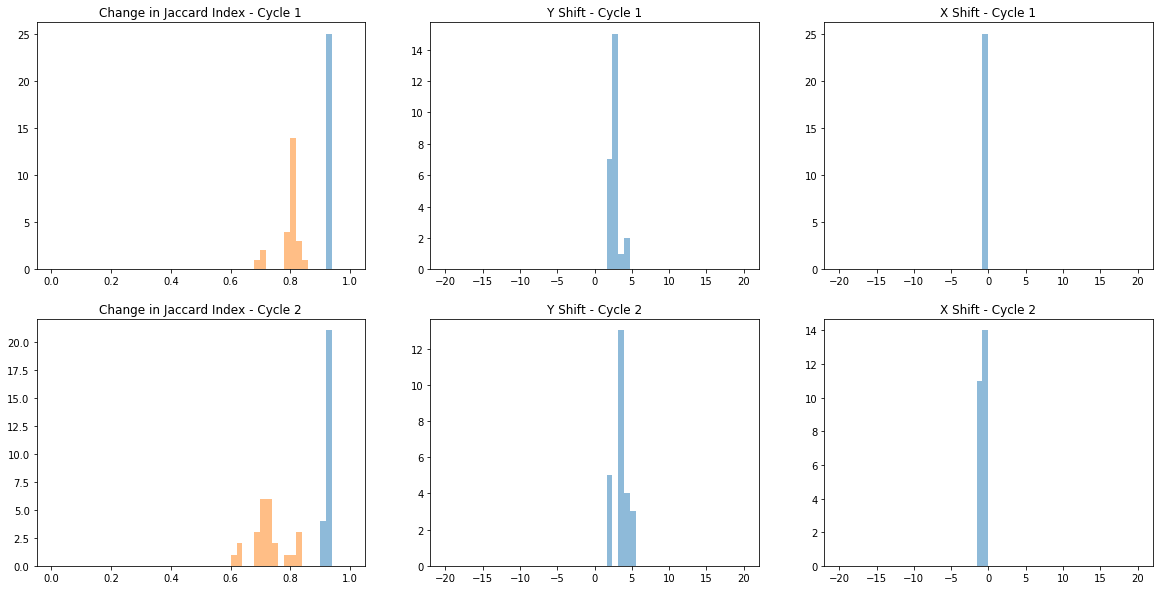

In [12]:
fig, axs = plt.subplots(CYCLE_NUMS-1, 3, figsize=(20,10))

for cycle in range(CYCLE_NUMS-1):
    axs[cycle][0].hist(reg_J[f'{cycle+1}'], bins = 50, alpha=0.5, label='reg_J', range=[0,1])
    axs[cycle][0].hist(base_J[f'{cycle+1}'], bins = 50, alpha=0.5, label='base_J', range=[0,1])
    
    axs[cycle][1].hist(dfY_shift[f'{cycle+1}'], bins = 50, alpha=0.5, label='dfX_shift', range=[-20,20])
    axs[cycle][2].hist(dfX_shift[f'{cycle+1}'], bins = 50, alpha=0.5, label='dfX_shift', range=[-20,20])
    
    axs[cycle][0].title.set_text(f'Change in Jaccard Index - Cycle {cycle+1}')
    axs[cycle][1].title.set_text(f'Y Shift - Cycle {cycle+1}')
    axs[cycle][2].title.set_text(f'X Shift - Cycle {cycle+1}')

#     for ax in axs.flat:
#         ax.set(xlabel='', ylabel='')

# X and Y Shift Visualization

If you want to look at the X and Y shifts for the FOVs of a Cycle all at once, follow this documentation:
https://docs.google.com/document/d/1Uq9HvGrfsr2ouOF2G_iSteotao5TVL7JSXSAZJjwyH4/edit

Text(0.5, 0.98, 'Cycle 1 Y-shift')

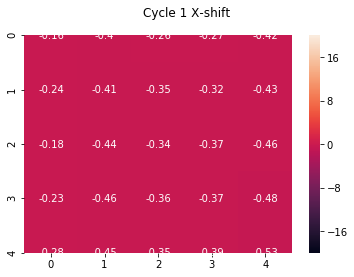

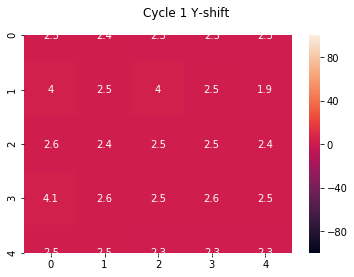

In [27]:
cycle_to_check = 1     # define which cycle you are checking - in this example, we are checking Cycle 1 

fig, axes = plt.subplots()
tmats = iter(glob.glob(f'tmat_Cyc_{cycle_to_check}/*'))
dfX = pd.DataFrame(0, index=['0','1','2', '3', '4'], # change for number of rows - this example is 5 rows (0 to 4)
               columns=['0','1','2', '3', '4']) # change for number of columns - this example is 5 columns (0 to 4)
dfY = pd.DataFrame(0, index=['0','1','2', '3', '4'], # change for number of rows - this example is 5 rows (0 to 4)
               columns=['0','1','2', '3', '4']) # change for number of columns - this example is 5 columns (0 to 4)
for sFOV in range(0,NUM_FOVS):
    tmat_name = next(tmats)
    tmat_loaded = np.load(tmat_name)
    moveX = tmat_loaded[0,2]
    moveY = tmat_loaded[1,2]

    col = str(int(tmat_name.split('_')[6]))
    row = str(int(tmat_name.split('_')[7][0:3]))

    dfX.loc[row, col] = moveX
    dfY.loc[row, col] = moveY

sns.heatmap(dfX, vmin=-20, vmax=20, annot=True)
pl.suptitle(f"Cycle {cycle_to_check} X-shift")
    
fig, axes = plt.subplots()
sns.heatmap(dfY, vmin=-100, vmax=100, annot=True)
pl.suptitle(f"Cycle {cycle_to_check} Y-shift")

# Merging and Cropping

In this step, we are merging all of the channels across all cycles, and then cropping the images so that the rotation artifacts from registration is not included in the final images.

In [ ]:
# Make sure NUM_FOVS is correctly defined
NUM_FOVS

In [ ]:
# checking for X and Y shifts, both min and max

x_max_list=[]
x_min_list=[]
y_max_list=[]
y_min_list=[]
X_indices =[]
Y_indices =[]
X_SHIFT_df = pd.DataFrame
Y_SHIFT_df = pd.DataFrame

for c in range(CYCLE_NUMS-1):     
    tmats = iter(glob.glob(f'tmat_Cyc_{c+1}/*'))
    X_SHIFT = []
    Y_SHIFT = []
    X_RIG = []
    Y_RIG = []
    for sFOV in range(0,NUM_FOVS): 
        tmat_name = next(tmats)
        fov = tmat_name.split('_F')[1][0:3]
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]
        if moveX > 0:
            moveX = moveX + 2048*np.tan(np.arcsin(tmat_loaded[0,1]))
            X_RIG = []
        if moveY < 0:
            moveY = moveY - 2048*np.tan(np.arcsin(tmat_loaded[0,1]))
        X_SHIFT.append(moveX)
        Y_SHIFT.append(moveY)
        
#         X_SHIFT_df.loc[fov, c] = moveX
#         Y_SHIFT_df.loc[fov, c] = moveY

    X_max = max(X_SHIFT)
    X_min = min(X_SHIFT)
    Y_max = max(Y_SHIFT)
    Y_min = min(Y_SHIFT)

    print('\n', f'tmat_Cyc_{c+1} \n', X_max,X_min,Y_max,Y_min)

    def round_shift(val):
        import math
        if val <0: # if negative,
            val = math.floor(val)
        else:
            val = math.ceil(val)
        return val

    X_max = round_shift(X_max)
    X_min = round_shift(X_min)
    Y_max = round_shift(Y_max)
    Y_min = round_shift(Y_min)
    
    x_max_list.append(X_max)
    x_min_list.append(X_min)
    y_max_list.append(Y_max)
    y_min_list.append(Y_min)
    print(f'X_max:{X_max}',f'X_min:{X_min}',f'Y_max:{Y_max}',f'Y_min:{Y_min}')

X_max_total = max(x_max_list)
X_min_total = min(x_min_list)
Y_max_total = max(y_max_list)
Y_min_total = min(y_min_list)

print('\n', f'X_max_total:{X_max_total}', f'X_min_total:{X_min_total}', 
      f'Y_max_total:{Y_max_total}', f'Y_min_total:{Y_min_total}')

# X_SHIFT_df.to_csv('X_SHIFT_df.csv',sep=',')
# Y_SHIFT_df.to_csv('Y_SHIFT_df.csv',sep=',')

In [ ]:
# checking shape of a reference image and defining the X and Y dimensions before cropping

im1 = imread('tif/Cycle_0/Cycle_F000.tif')
Y_total = len(im1[0][0][0])    # 2048
X_total = len(im1[0][0][1])    # 2048
print(Y_total, X_total)

In [ ]:
# defining the cropping function 

X_abs_shift = [abs(X_max_total), abs(X_min_total)]
Y_abs_shift = [abs(Y_max_total), abs(Y_min_total)] 

def crop(X_x, X_n, Y_x, Y_n, img, pad):
    Y_total = img.shape[3]    # 2048
    X_total = img.shape[-1]     # 2048
    print('image shape', Y_total, X_total)
    
    if X_x * X_n > 0:   # same signs --> both negative or both positive
        Xlength = X_total - (max(X_abs_shift))
        print(Xlength)
        if X_x > 0: # moving left
            img = img[...,:, 0+pad:Xlength-pad]
        if X_x < 0:  # moving right 
            img = img[...,:, abs(X_n)+pad:X_total-pad]

    if X_x * X_n < 0:   # diff signs --> one is positive and other is negative
        Xlength = X_total  - (abs(X_x) + abs(X_n))
        print(Xlength)
        img = img[...,:, abs(X_n)+pad: X_total - abs(X_x)-pad] 
        
    if X_x == 0 and X_n < 0:
        Xlength = X_total  - abs(X_n)
        print(Xlength)
        img = img[...,:, abs(X_n)+pad:X_total-pad]
    if X_x == 0 and X_n == 0:
        Xlength = X_total
        print(Xlength)
        img = img[...,:, 0+pad:X_total-pad]
    if X_x > 0 and X_n == 0:
        Xlength = X_total - X_x
        print(Xlength)
        img = img[...,:, 0+pad:Xlength-pad]
### Y ## #
    if Y_x * Y_n > 0:   
        Ylength = Y_total - (max(Y_abs_shift))
        print(Ylength)
        if Y_x > 0: # up
            img = img[..., 0+pad:Ylength-pad, :]
        if Y_x < 0: # down
            img = img[...,abs(Y_n)+pad:Y_total-pad, :]
            
    if Y_x * Y_n < 0:  # Y_x > 0 , Y_n < 0
        Ylength = Y_total  - (abs(Y_x) + abs(Y_n)) # 
        print(Ylength)
        img = img[...,abs(Y_n)+pad:Y_total-abs(Y_x)-pad, :] 
        
    if Y_x == 0 and Y_n < 0: # down
        Ylength = Y_total  - abs(Y_n)
        print(Ylength)
        img = img[..., abs(Y_n)+pad:Y_total-pad, :]
        
    if Y_x == 0 and Y_n == 0:
        Ylength = Y_total
        print(Ylength)
        img = img[..., 0+pad:Y_total-pad,:]
        
    if Y_x > 0 and Y_n == 0:
        Ylength = Y_total - Y_x ## 
        print(Ylength)
        img = img[..., 0+pad:Ylength-pad, :] ## up  
    Xlength = Xlength - (pad*2)
    Ylength = Ylength - (pad*2)
    return Xlength, Ylength, img

In [ ]:
IN_DIR = 'reg'
MERGE_DIR = 'merged' # output directory to save
Z = 10
final_ch = 10  # final channel number

pad = 10 # 10 pixel padding

!mkdir merged
!mkdir max 
!mkdir images_2_channel

In [ ]:
# Running merge and crop

refs = iter(glob.glob('tif/Cycle_0/*')) 
for FOV in range(NUM_FOVS):
    ref_name = next(refs)
    FOV_num = ref_name.split('_F')[1][0:3]
    print("FOV", FOV_num)
    #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
    img = imread(f'tif/Cycle_0/Cycle_F{FOV_num}.tif') # reference image that did not move
    img = img.astype(np.uint16)
    print("image max:",img.max())
    for cycle in range(CYCLE_NUMS-1):    
        fname = f'{IN_DIR}_Cyc_{cycle+1}/Cycle_{cycle+1}_F{FOV_num}_{IN_DIR}.tif'
        print('Appending... ', fname)
        im_to_add = imread(fname).astype(np.uint16)
        print(im_to_add.max())
        im_to_add[:,0,...] = img[:,0,...]
        img_last_3 = img[:,1:,...]
        img = np.append(im_to_add, img_last_3, axis=1) # concatenate along channel index
        print(f"Shape = {img.shape}") 
    fname = f'/F{FOV_num}.tif'
    print('saving', './{MERGE_DIR}'+fname)
    print('dtype of ', img.dtype)

    ########## CROP ################ --> CHANGE everytime depending on shifts
    Xlength, Ylength, img = crop(X_max_total, X_min_total, Y_max_total, Y_min_total, img, pad)

    assert img.shape[3] == Xlength, "Check X size"
    assert img.shape[2] == Ylength, "Check Y size"

    ### FINAL CHECK before saving ### 
    print("image Z:",img.shape[0])
    assert img.shape[0] == Z, "Check ZCYX"
    print("image final_ch:",img.shape[1])
    assert img.shape[1] == final_ch, "check final merge size"
    print("image max:", img.max())

    tifffile.imwrite(
        f'./{MERGE_DIR}'+fname,
        img,
        imagej=True,
        photometric='minisblack',
        metadata={'axes': 'ZCYX'},
    )

    del img # clear memory
    del im_to_add
    
for i in range(NUM_FOVS):
    try:
        sFOV = str(i).zfill(3)
        im = imread(f'merged/F{sFOV}.tif')
        max_im = im.max(0)
        tifffile.imwrite(f'max/F{sFOV}_max.tif', max_im, imagej=True, photometric = 'minisblack',metadata={'axes':'CYX'})
    except:
        continue

for i in range(NUM_FOVS):
    try:
        print(i)
        FOV = str(i).zfill(3)
        im_name = f'max/F{FOV}_max.tif'
        im1 = imread(im_name)
        im1_save = im1[[0, 1], ...]   ### CHANGE THIS DEPENDING ON THE DATA -- DNA AND RNA CHANNELS
        tifffile.imwrite(f'images_2_channel/F{FOV}_max.tif', im1_save, imagej=True, photometric = 'minisblack',metadata={'axes':'CYX'})
    except:
        print(i, "does not exist")

# You can end the pipeline here and move onto cell segmentation: https://docs.google.com/document/d/1Hv0edCc2tVscYzYVikYOnAQ2kpr2FL43yKQp3d3ghVw/edit
# -----------------------------------------------------------------------------------------------------------------

# Or, you can do additional QC if you think your dataset might have pixel intensity errors or file corruption:


# Extreme Pixel Intensity Check

In this step, we are checking for any extreme pixel intensities, which can be a result from technical artifact, image corruption, or registration artifact. Here are some example images:
https://docs.google.com/document/d/1WVpozq1bkTRrcFzSM9a1nZV3uN38_Mcf0io2X5xNlyI/edit

In [ ]:
# creating a dataframe of potential extremel pixel intensities

int_counts = pd.DataFrame()
one_to_five_list = []
sixfivek_list = []
z_list = []

merged = iter(glob.glob('merged/*')) 
for FOV in range(NUM_FOVS):
    merged_name = next(merged)
    img = imread(merged_name)
    img = img.astype(np.uint16)
    FOV_num = merged_name.split('/F')[1][0:3]
    print("FOV", FOV_num)
    
    overall_count_zero = np.count_nonzero(img == 0)
    x = np.count_nonzero((0 < img) & (img < 6))
    y = np.count_nonzero(65000 < img)
     
    for Z in range(img.shape[0]):
        print(Z)
        for ch in range(img.shape[1]): 
            count_zeros = np.count_nonzero(img[Z,ch,...] == 0)
            if count_zeros > 0:
                z_list.append((FOV_num, Z, ch))
            count = np.count_nonzero((0 < img[Z,ch,...]) & (img[Z,ch,...] < 6))
            if count > 0:
                one_to_five_list.append((FOV_num, Z, ch))
            count = np.count_nonzero(65000 < img[Z,ch,...])
            if count > 0:
                sixfivek_list.append((FOV_num, Z, ch))
                
    int_counts.loc[FOV_num, 'FOV_num'] = FOV_num
    int_counts.loc[FOV_num, 'total Zero count'] = overall_count_zero
    int_counts.loc[FOV_num, 'one to five'] = x
    int_counts.loc[FOV_num, 'greater 65K'] = y
int_counts.to_csv('output/pixel_intensity_counts_table.csv')    


In [ ]:
int_counts

In [ ]:
len(sixfivek_list)

In [ ]:
len(one_to_five_list)

In [ ]:
len(z_list)

In [ ]:
for idx, val in enumerate(int_counts['greater 65K']):
    if val != 0:
        print(int(int_counts.iloc[idx, 2]), "FOV:", int_counts.iloc[idx, 0])

In [ ]:
for idx, val in enumerate(int_counts['one to five']):
    if val != 0:
        print(int(int_counts.iloc[idx, 2]), "FOV:", int_counts.iloc[idx, 0])

In [ ]:
for idx, val in enumerate(int_counts['total Zero count']):
    if val != 0:
        print(int(int_counts.iloc[idx, 2]), "FOV:", int_counts.iloc[idx, 0])

In [ ]:
# LOOKING FOR WHICH FOVS HAVE THE BLACK BOXES
black_box = []
for idx, val in enumerate(int_counts['total Zero count']):
    if val > 2000:
        black_box.append(int_counts.iloc[idx, 0])
        print(int_counts.iloc[idx, 0], val)
black_box

In [ ]:
len(black_box)

# Black Box 

This is a continuation of looking for artifacts that can affect downstream analysis. Black boxes specifically are from image corruption. It is best to get rid of FOVs that might have such artifacts. Here is the document with the example: https://docs.google.com/document/d/1WVpozq1bkTRrcFzSM9a1nZV3uN38_Mcf0io2X5xNlyI/edit

In [ ]:
df_black_box = pd.DataFrame()
for idx, i in enumerate(z_list):
    if i[0] in black_box:
        df_black_box.loc[idx, 'FOV_num'] = i[0]
        df_black_box.loc[idx, 'Z'] = i[1]
        df_black_box.loc[idx, 'channel'] = i[2]
        
df_black_box
df_black_box.to_csv('output/black_box_locations.csv')

In [ ]:
# total num of pixels is 3995601 (because 2019*1979)
total = img.shape[2] * img.shape[3]
# here we get percent of 0 intensity count, 0<x<6 and greater than 65k
percents = int_counts.copy()
percents['total Zero count'] = percents['total Zero count'].div(total)
percents['one to five'] = percents['one to five'].div(total)
percents['greater 65K'] = percents['greater 65K'].div(total)
percents

In [ ]:
percents.to_csv('output/percent_intensity_table.csv')

In [ ]:
# Obtain percentiles of pixel intensities
percentiles = pd.DataFrame()

merged = iter(glob.glob('merged/*')) 
for FOV in range(NUM_FOVS):
    merged_name = next(merged)
    img = imread(merged_name)
    img = img.astype(np.uint16)
    FOV_num = merged_name.split('/F')[1][0:3]
    print("FOV", FOV_num)

    for ch in range(img.shape[1]): 
        arr = img[:,ch,...]
        percent = 0
        while np.percentile(arr, percent) == 0:
            percent += 1
        percentiles.loc[FOV_num, f'ch{ch}_cutoff_perc'] = percent # by the +1, you will know if there are ANY 0's
        
        percentiles.loc[FOV_num, f'ch{ch}_0th_perc'] = np.percentile(arr, 0)
        percentiles.loc[FOV_num, f'ch{ch}_0.001st_perc'] = np.percentile(arr, 0.001)
        percentiles.loc[FOV_num, f'ch{ch}_0.01st_perc'] = np.percentile(arr, 0.01)
        percentiles.loc[FOV_num, f'ch{ch}_0.1st_perc'] = np.percentile(arr, 0.1)
        percentiles.loc[FOV_num, f'ch{ch}_0.5th_perc'] = np.percentile(arr, 0.5)
        percentiles.loc[FOV_num, f'ch{ch}_1st_perc'] = np.percentile(arr, 1)
        percentiles.loc[FOV_num, f'ch{ch}_5th_perc'] = np.percentile(arr, 5)
        percentiles.loc[FOV_num, f'ch{ch}_10th_perc'] = np.percentile(arr, 10)
        percentiles.loc[FOV_num, f'ch{ch}_90th_perc'] = np.percentile(arr, 90)
        percentiles.loc[FOV_num, f'ch{ch}_95th_perc'] = np.percentile(arr, 95)
        percentiles.loc[FOV_num, f'ch{ch}_99th_perc'] = np.percentile(arr, 99)
        percentiles.loc[FOV_num, f'ch{ch}_100th_perc'] = np.percentile(arr, 100)


percentiles.to_csv('percentiles.csv')

In [ ]:
percentiles

In [ ]:
zeroth_perc = percentiles.filter(regex=(".*_0th.*"))
zeroth_perc

In [ ]:
# histogram of max 0th percentile values across all channels

plt.hist(zeroth_perc.max().to_frame()[0],bins = 20)

In [ ]:
# replace with whatever channel you want to check
plt.hist(percentiles['ch0_0th_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '0_perc')
plt.hist(percentiles['ch0_0.001st_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '0.001_perc')
plt.hist(percentiles['ch0_0.1st_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '0.1_perc')
plt.hist(percentiles['ch0_5th_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '5_perc')
plt.hist(percentiles['ch0_10th_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '10_perc')
plt.legend(loc='upper left')
plt.suptitle(f"Channel 0 -- percentiles")

In [ ]:
### for looking at all of the channels 
for i in range(38):
    fig, axes = plt.subplots()
    plt.hist(percentiles[f'ch{i}_0th_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '0_perc')
    plt.hist(percentiles[f'ch{i}_0.001st_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '0.001_perc')
    plt.hist(percentiles[f'ch{i}_0.1st_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '0.1_perc')
    plt.hist(percentiles[f'ch{i}_5th_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '5_perc')
    plt.hist(percentiles[f'ch{i}_10th_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '10_perc')
    plt.legend(loc='upper left')
    plt.suptitle(f"Channel {i} -- percentiles")
    
#     fig, axes = plt.subplots()
#     sns.heatmap(dfY, vmin=-100, vmax=100)
#     pl.suptitle(f"Cycle {c+1} Y-shift")